Using device: cpu
Sampled 30 linear trajectories (pairs of test images).

Training model: activation=linear, depth=8
Epoch 1/5 | Train Loss: 0.5481 | Val Acc: 0.8971
Epoch 2/5 | Train Loss: 0.3946 | Val Acc: 0.8900
Epoch 3/5 | Train Loss: 0.3842 | Val Acc: 0.8936
Epoch 4/5 | Train Loss: 0.3627 | Val Acc: 0.8998
Epoch 5/5 | Train Loss: 0.3493 | Val Acc: 0.8948
Test Accuracy: 0.8966
Computing layerwise trajectory expansion (linear trajectories)...
  Layer  1 | trajectories used: 30 | R_mean = 0.8937 | R_std = 0.2205
  Layer  2 | trajectories used: 30 | R_mean = 1.1194 | R_std = 0.2914
  Layer  3 | trajectories used: 30 | R_mean = 1.3788 | R_std = 0.3609
  Layer  4 | trajectories used: 30 | R_mean = 1.6625 | R_std = 0.4481
  Layer  5 | trajectories used: 30 | R_mean = 1.9170 | R_std = 0.5158
  Layer  6 | trajectories used: 30 | R_mean = 2.1618 | R_std = 0.5865
  Layer  7 | trajectories used: 30 | R_mean = 2.4148 | R_std = 0.6573
  Layer  8 | trajectories used: 30 | R_mean = 2.9228 | R_std

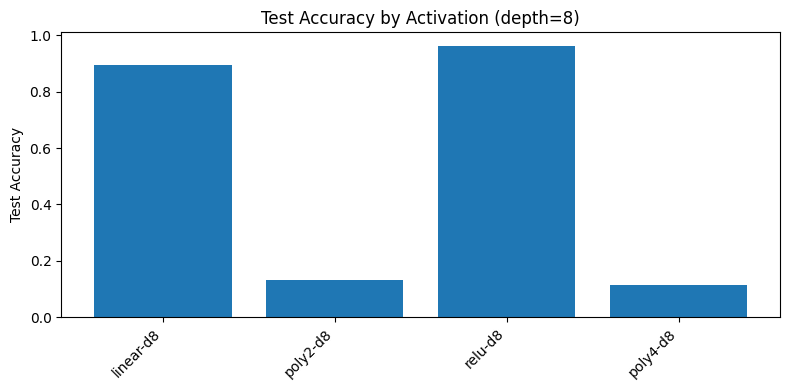

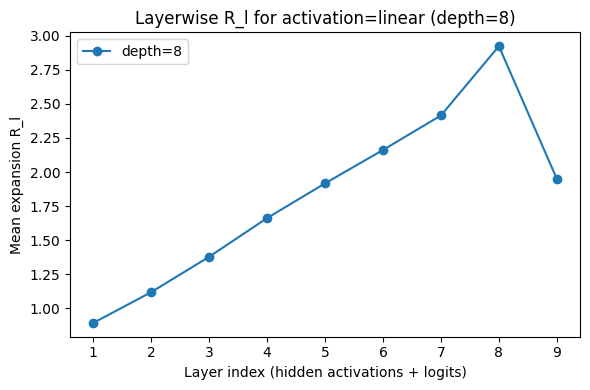

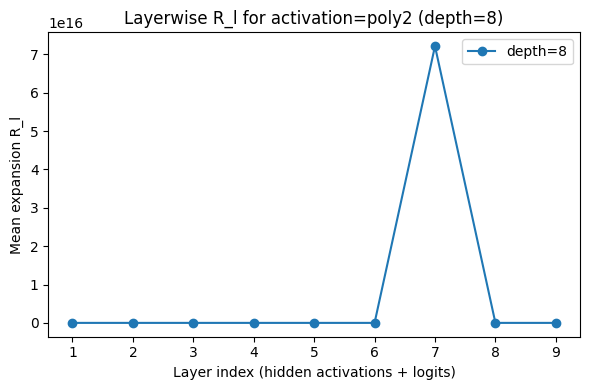

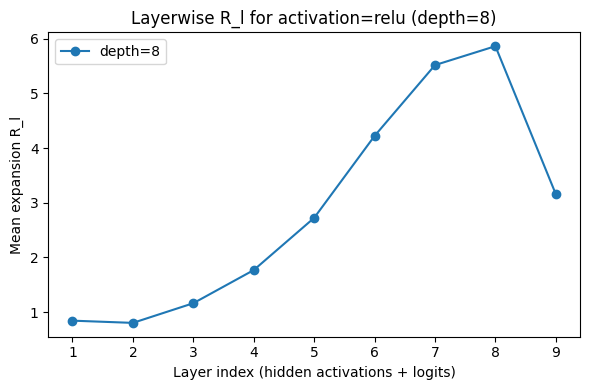

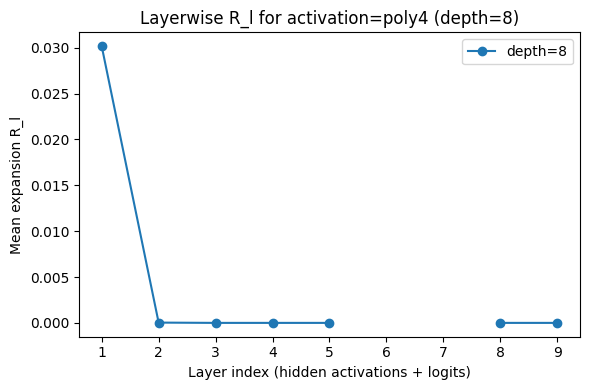


===== SUMMARY (per model) =====
Act=linear | depth= 8 | test_acc=0.8966 | num_layers=9
Act= poly2 | depth= 8 | test_acc=0.1321 | num_layers=9
Act=  relu | depth= 8 | test_acc=0.9629 | num_layers=9
Act= poly4 | depth= 8 | test_acc=0.1135 | num_layers=9


In [8]:
# AM 210 final project experiment

import os
import random
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt


# Helpers, setting seed and get device
def set_seed(seed: int = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading and separating test/train for MNIST

def get_mnist_loaders(batch_size=128, val_size=10000):
    transform = transforms.ToTensor()

    train_full = torchvision.datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )
    test_dataset = torchvision.datasets.MNIST(
        root="./data", train=False, download=True, transform=transform
    )

    train_size = len(train_full) - val_size
    train_dataset, val_dataset = random_split(
        train_full,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(0),
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


# Defining models for different activations
class PolyActivation(nn.Module):
    def __init__(self, degree: int):
        super().__init__()
        self.degree = degree

    def forward(self, x):
        return x ** self.degree


class LinearIdentity(nn.Module):
    def forward(self, x):
        return x


class MLP(nn.Module):
    """
    MLP with "depth" amount of hidden layers
    """
    def __init__(self, input_dim, hidden_dim, output_dim, depth, activation):
        super().__init__()

        layers = []
        # First hidden layer
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(activation)

        # Additional hidden layers
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(activation)

        self.hidden = nn.Sequential(*layers)
        self.out_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.hidden(x)
        x = self.out_layer(x)
        return x


def build_model(depth, activation_name, input_dim=784, hidden_dim=128, output_dim=10):
    if activation_name == "relu":
        act = nn.ReLU()
    elif activation_name == "linear":
        act = LinearIdentity()
    elif activation_name == "poly2":
        act = PolyActivation(degree=2)
    elif activation_name == "poly4":
        act = PolyActivation(degree=4)
    else:
        raise ValueError(f"Unknown activation {activation_name}")

    return MLP(input_dim, hidden_dim, output_dim, depth, act)


# Numerical guard for cases to ensure experiment runs with high degree polynomial + high depth networks
def model_has_finite_params(model):
    with torch.no_grad():
        for p in model.parameters():
            if not torch.isfinite(p).all():
                return False
    return True


# Training, evaluation of classifcation accuracy
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss, total = 0.0, 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        if not torch.isfinite(loss):
            print("  [WARNING] Non-finite loss encountered — stopping epoch.")
            return float("nan")

        loss.backward()
        optimizer.step()

        if not model_has_finite_params(model):
            print("  [WARNING] Parameters became non-finite — stopping epoch.")
            return float("nan")

        running_loss += loss.item() * inputs.size(0)
        total += inputs.size(0)

    return running_loss / total if total > 0 else float("nan")


def evaluate_accuracy(model, loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if not torch.isfinite(outputs).all():
                continue  # skipping broken batches to make experiment keep running

            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)

    return correct / total if total > 0 else float("nan")


def train_model(model, train_loader, val_loader, device, epochs=5, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_acc = evaluate_accuracy(model, val_loader, device)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

        if not torch.isfinite(torch.tensor(train_loss)) or not torch.isfinite(torch.tensor(val_acc)):
            print("  [Warning] Non-finite metric — stopping training for this model.")
            break

        if not model_has_finite_params(model):
            print("  [Warning] Parameters non-finite — stopping training for this model.")
            break



# sampling linear trajectories from the dataset, used for trajectory length comparisons
def sample_line_pairs(dataset, num_pairs=30):
    """
    Randomly sample index pairs (i, j) from the dataset, which will serve as endpoints of
    the linear trajecotires
    """
    n = len(dataset)
    indices = random.sample(range(n), min(2 * num_pairs, n))
    # form consecutive pairs: (idx[0], idx[1]), (idx[2], idx[3]), ...
    pairs = []
    for k in range(0, len(indices) - 1, 2):
        pairs.append((indices[k], indices[k + 1]))
    return pairs


def build_line_trajectory(x0: torch.Tensor,
                          x1: torch.Tensor,
                          num_steps: int,
                          device: torch.device = torch.device("cpu")):
    """
    Build a linear trajectory between x0 and x1
    """
    x0 = x0.view(-1).to(device)
    x1 = x1.view(-1).to(device)
    t = torch.linspace(0.0, 1.0, steps=num_steps, device=device).unsqueeze(1)  # (num_steps, 1)
    xs = x0.unsqueeze(0) + t * (x1.unsqueeze(0) - x0.unsqueeze(0))  # (num_steps, dim)
    return xs


def forward_collect_layer_outputs(model: MLP, xs: torch.Tensor):
    """
    Forward pass, collects output after each activation in hidden layers
    """
    layer_outputs = []
    h = xs.view(xs.size(0), -1)
    # step through hidden Sequential: Linear, Act, Linear, Act, ...
    for module in model.hidden:
        h = module(h)
        # Treat the activation modules as layer boundaries
        if isinstance(module, (LinearIdentity, nn.ReLU, PolyActivation)):
            layer_outputs.append(h)
    # final output layer
    logits = model.out_layer(h)
    layer_outputs.append(logits)
    return layer_outputs


def compute_layerwise_trajectory_expansion_lines(
    model,
    dataset,
    pairs,
    device,
    num_steps=50,
):
    """
    For each (x0, x1) pair, build a linear trajectory between those images and compute
    trajectory length at each layer output, returning expansion ratio
    R_l = L_out_layer / L_input for each layer
    """
    if not model_has_finite_params(model):
        print("  [Warning] Model broken before trajectory computation — skipping.")
        return [], [], []

    model.eval()
    model.to(device)

    layer_ratios = None

    with torch.no_grad():
        for (i0, i1) in pairs:
            x0, _ = dataset[i0]
            x1, _ = dataset[i1]
            x0 = x0.view(-1).to(device)
            x1 = x1.view(-1).to(device)

            xs = build_line_trajectory(
                x0,
                x1,
                num_steps=num_steps,
                device=device,
            )  # (num_steps, 784)

            # Find input trajectory length
            dx = xs[1:] - xs[:-1]
            l_in = dx.norm(p=2, dim=1).sum().item()
            if l_in == 0 or not torch.isfinite(torch.tensor(l_in)):
                continue

            # Collect layer outputs
            layer_outputs = forward_collect_layer_outputs(model, xs)

            # Initialize ratio containers
            if layer_ratios is None:
                num_layers = len(layer_outputs)
                layer_ratios = [[] for _ in range(num_layers)]

            # Skip this trajectory if any layer output is non-finite
            skip_traj = False
            for y in layer_outputs:
                if not torch.isfinite(y).all():
                    skip_traj = True
                    break
            if skip_traj:
                continue

            # For each layer, compute trajectory length and ratio
            for l_idx, y in enumerate(layer_outputs):
                dy = y[1:] - y[:-1]
                l_out = dy.norm(p=2, dim=1).sum().item()
                if l_out == 0 or not torch.isfinite(torch.tensor(l_out)):
                    continue
                R = l_out / l_in
                layer_ratios[l_idx].append(R)

    if layer_ratios is None:
        return [], [], []

    R_means, R_stds, counts = [], [], []
    for ratios in layer_ratios:
        if len(ratios) == 0:
            R_means.append(float("nan"))
            R_stds.append(float("nan"))
            counts.append(0)
        else:
            R_t = torch.tensor(ratios, dtype=torch.float32)
            R_means.append(float(R_t.mean().item()))
            R_stds.append(float(R_t.std().item()))
            counts.append(len(ratios))

    return R_means, R_stds, counts  # one entry per layer (hidden blocks + logits)


# Run experiment and visualize results
def run_experiment():
    set_seed(0)
    device = get_device()
    print(f"Using device: {device}")

    depths = [8]
    activations = ["linear", "poly2", "relu", "poly4"]

    train_loader, val_loader, test_loader = get_mnist_loaders()
    test_dataset = test_loader.dataset

    pairs = sample_line_pairs(test_dataset, num_pairs=30)
    print(f"Sampled {len(pairs)} linear trajectories (pairs of test images).\n")

    results = []

    for act in activations:
        for depth in depths:
            print("=" * 80)
            print(f"Training model: activation={act}, depth={depth}")
            model = build_model(depth, act)

            train_model(model, train_loader, val_loader, device, epochs=5, lr=1e-3)

            test_acc = evaluate_accuracy(model, test_loader, device)
            print(f"Test Accuracy: {test_acc:.4f}")

            print("Computing layerwise trajectory expansion (linear trajectories)...")
            R_means, R_stds, counts = compute_layerwise_trajectory_expansion_lines(
                model,
                test_dataset,
                pairs,
                device,
                num_steps=50,
            )

            # Pretty-print per-layer R
            for l_idx, (m, s, c) in enumerate(zip(R_means, R_stds, counts)):
                print(
                    f"  Layer {l_idx+1:2d} | trajectories used: {c:2d} | "
                    f"R_mean = {m:.4f} | R_std = {s:.4f}"
                )

            results.append(
                {
                    "activation": act,
                    "depth": depth,
                    "test_acc": test_acc,
                    "R_means": R_means,
                    "R_stds": R_stds,
                }
            )

    # Bar chart of classification performance
    labels = []
    accs = []
    for r in results:
        labels.append(f"{r['activation']}-d{r['depth']}")
        accs.append(r["test_acc"])

    plt.figure(figsize=(8, 4))
    x = range(len(labels))
    plt.bar(x, accs)
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel("Test Accuracy")
    plt.title("Test Accuracy by Activation (depth=8)")
    plt.tight_layout()
    plt.show()

    # Line plots of R_mean vs layer for each neural network architecture
    for act in activations:
        plt.figure(figsize=(6, 4))
        for r in results:
            if r["activation"] != act:
                continue
            depth = r["depth"]
            R_means = r["R_means"]
            if len(R_means) == 0:
                continue
            layers = list(range(1, len(R_means) + 1))
            plt.plot(layers, R_means, marker="o", label=f"depth={depth}")
        plt.xlabel("Layer index (hidden activations + logits)")
        plt.ylabel("Mean expansion R_l")
        plt.title(f"Layerwise R_l for activation={act} (depth=8)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Text summary
    print("\n===== SUMMARY (per model) =====")
    for r in results:
        L = len(r["R_means"])
        print(
            f"Act={r['activation']:>6} | depth={r['depth']:>2} | "
            f"test_acc={r['test_acc']:.4f} | num_layers={L}"
        )


if __name__ == "__main__":
    run_experiment()
